In [ ]:
# Install MediaPipe for video processing
!pip install mediapipe==0.10.7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.6/33.6 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import cv2
import mediapipe as mp
from scipy.stats import mode
%matplotlib inline


# Load the dataset
df = pd.read_csv('/content/hand_landmarks_data.csv')
df.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25675 entries, 0 to 25674
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      25675 non-null  float64
 1   y1      25675 non-null  float64
 2   z1      25675 non-null  float64
 3   x2      25675 non-null  float64
 4   y2      25675 non-null  float64
 5   z2      25675 non-null  float64
 6   x3      25675 non-null  float64
 7   y3      25675 non-null  float64
 8   z3      25675 non-null  float64
 9   x4      25675 non-null  float64
 10  y4      25675 non-null  float64
 11  z4      25675 non-null  float64
 12  x5      25675 non-null  float64
 13  y5      25675 non-null  float64
 14  z5      25675 non-null  float64
 15  x6      25675 non-null  float64
 16  y6      25675 non-null  float64
 17  z6      25675 non-null  float64
 18  x7      25675 non-null  float64
 19  y7      25675 non-null  float64
 20  z7      25675 non-null  float64
 21  x8      25675 non-null  float64
 22

In [ ]:
df[["label"]].value_counts()

,count
label,
three2,1653
palm,1649
four,1634
ok,1592
stop_inverted,1567
call,1506
peace_inverted,1497
stop,1482
rock,1458


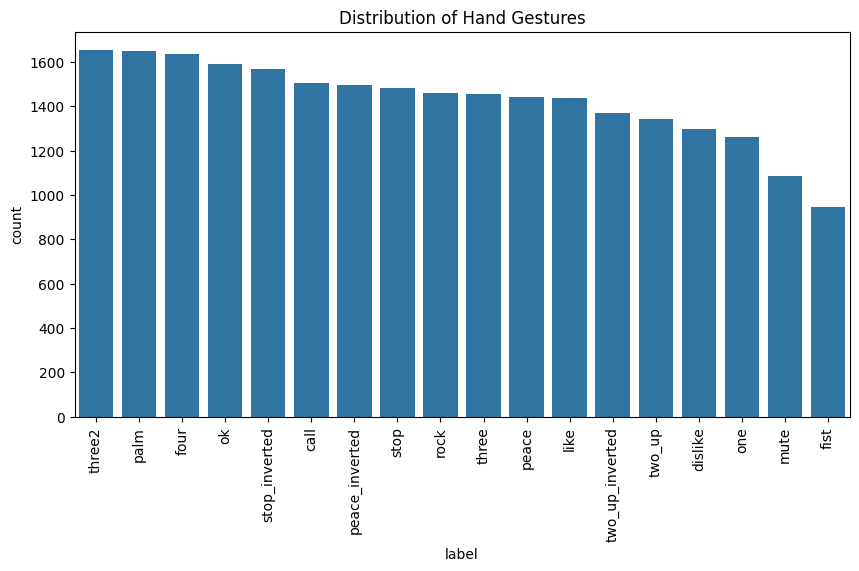

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x=df['label'], order=df['label'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Distribution of Hand Gestures')
plt.show()

In [ ]:
df.dropna(inplace=True)
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

def preprocess_landmarks(row):
    wrist_x, wrist_y = row[0], row[1]
    mid_finger_x, mid_finger_y = row[36], row[37]  # Tip of the middle finger (landmark 12)

    processed = []
    for i in range(0, 63, 3):  # x, y, z for 21 landmarks
        x = row[i] - wrist_x
        y = row[i+1] - wrist_y
        x /= mid_finger_x - wrist_x
        y /= mid_finger_y - wrist_y
        z = row[i+2]  # z is already processed
        processed.extend([x, y, z])
    return processed

features = df.drop('label', axis=1)
labels = df['label']
processed_features = features.apply(preprocess_landmarks, axis=1, result_type='expand')

<ipython-input-6-0f356e85b6a3>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  wrist_x, wrist_y = row[0], row[1]
<ipython-input-6-0f356e85b6a3>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mid_finger_x, mid_finger_y = row[36], row[37]  # Tip of the middle finger (landmark 12)
<ipython-input-6-0f356e85b6a3>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = row[i] - wrist_x
<ipython-input-6-0f356e85b6a3>:12: FutureWarning: Se

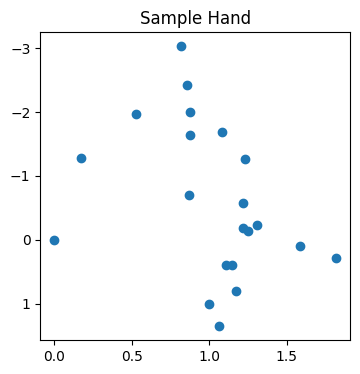

In [ ]:
def plot_hand(points, title='Hand Landmarks'):
    x = points[::3]
    y = points[1::3]
    plt.figure(figsize=(4,4))
    plt.scatter(x, y)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.show()

plot_hand(processed_features.iloc[0].values, title='Sample Hand')

In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=42, stratify=labels)

# Train different classifiers
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Evaluate the models
def evaluate_model(y_test, y_pred, model_name):
    print(f'--- {model_name} ---')
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    cm = confusion_matrix(y_test, y_pred)
    # plt.figure(figsize=(10, 8))
    # sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
    # plt.title(f'{model_name} Confusion Matrix')
    # plt.ylabel('Actual')
    # plt.xlabel('Predicted')
    # plt.show()

# Evaluate all models
evaluate_model(y_test, y_pred_rf, 'Random Forest')
evaluate_model(y_test, y_pred_svm, 'SVM')
evaluate_model(y_test, y_pred_knn, 'KNN')
evaluate_model(y_test, y_pred_lr, 'Logistic Regression')
evaluate_model(y_test, y_pred_dt, 'Decision Tree')
evaluate_model(y_test, y_pred_gb, 'Gradient Boosting')

--- Random Forest ---
                 precision    recall  f1-score   support

           call       0.99      0.98      0.99       301
        dislike       0.98      0.98      0.98       259
           fist       0.99      0.99      0.99       189
           four       0.97      0.96      0.96       327
           like       0.97      0.98      0.98       287
           mute       0.95      0.97      0.96       217
             ok       0.99      0.99      0.99       318
            one       0.95      0.95      0.95       253
           palm       0.93      0.95      0.94       330
          peace       0.95      0.93      0.94       288
 peace_inverted       0.98      0.95      0.96       299
           rock       1.00      0.98      0.99       292
           stop       0.91      0.94      0.93       296
  stop_inverted       0.98      0.99      0.98       314
          three       0.99      0.97      0.98       291
         three2       0.96      0.98      0.97       331
        

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Video input/output paths
input_path = '/content/WIN_20250422_20_07_53_Pro.mp4'
output_path = '/content/output_video.mp4'

# Initialize video capture
cap = cv2.VideoCapture(input_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

# Window for stabilization
prediction_window = []

with mp_hands.Hands(static_image_mode=False,
                    max_num_hands=1,
                    min_detection_confidence=0.7,
                    min_tracking_confidence=0.5) as hands:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(image)
        label = None
        if results.multi_hand_landmarks:
            hand_landmarks = results.multi_hand_landmarks[0]
            landmark_list = []
            for lm in hand_landmarks.landmark:
                landmark_list.extend([lm.x, lm.y, lm.z])
            coords = np.array(landmark_list)
            coords[0::3] *= width
            coords[1::3] *= height
            processed = preprocess_landmarks(coords)
            prediction = rf.predict([processed])[0]
            prediction_window.append(prediction)
            if len(prediction_window) > 5:
                prediction_window.pop(0)
            mode_prediction = mode(prediction_window)
            if isinstance(mode_prediction.mode, np.ndarray) and len(mode_prediction.mode) > 0:
                label = le.inverse_transform([mode_prediction.mode[0]])[0]
            else:
                label = le.inverse_transform([mode_prediction.mode])[0]
            cv2.putText(frame, f'Prediction: {label}', (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
        out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()
print(f'Output video saved to: {output_path}')

Output video saved to: /content/output_video.mp4


In [ ]:
import os
if os.path.exists('/content/output_video.mp4'):
    print("Video saved successfully at /content/output_video.mp4")
else:
    print("Video not found. Did the code run completely?")

Video saved successfully at /content/output_video.mp4


In [ ]:
from google.colab import files
files.download('/content/output_video.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from joblib import dump
import numpy as np

# Save the model, LabelEncoder, and preprocessing function
model_data = {
    'model': rf,  # Your trained RandomForest
    'label_encoder': le,  # Fitted LabelEncoder
    'preprocess_landmarks': preprocess_landmarks  # Your function from Colab
}

dump(model_data, 'hand_gesture_model_package.joblib')

# Download to your laptop
from google.colab import files
files.download('hand_gesture_model_package.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>